In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import os
import ast
import gdown

In [6]:

# https://drive.google.com/file/d/1a821cbJ9S7j_tdZnNNS5IDIEPVHTrjpA/view?usp=sharing
gdown.download(id='1a821cbJ9S7j_tdZnNNS5IDIEPVHTrjpA', output='03_manual_labelled_emails.csv', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1a821cbJ9S7j_tdZnNNS5IDIEPVHTrjpA
From (redirected): https://drive.google.com/uc?id=1a821cbJ9S7j_tdZnNNS5IDIEPVHTrjpA&confirm=t&uuid=bbbb5bdf-a47a-4d64-82db-417d6b81e441
To: /Users/pkchoy/code/data_science_bootcamp/predictor-with-files/notebooks/03_manual_labelled_emails.csv
100%|██████████| 136M/136M [00:08<00:00, 15.4MB/s] 


'03_manual_labelled_emails.csv'

In [7]:
# emails_df = pd.read_csv('../data/03_manual_labelled_emails.csv')
emails_df = pd.read_csv('03_manual_labelled_emails.csv')
emails_df.head()

,Date,From,To,Subject,X_From,X_To,Message,Entire-Message,DISC_rule,DISC_manual,DISC_final
0,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...,Re: Traveling to have a business meeting takes...,NaN,"['I', 'C']",NaN
1,"Mon, 16 Oct 2000 06:42:00 -0700 (PDT)",phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,Phillip K Allen,"""Buckner, Buck"" <buck.buckner@honeywell.com> @...","Mr. Buckner,\nFor delivered gas behind San Die...",Re: FW: fixed forward or other Collar floor ga...,NaN,['S'],NaN
2,"Fri, 13 Oct 2000 06:45:00 -0700 (PDT)",phillip.allen@enron.com,stagecoachmama@hotmail.com,No Subject,Phillip K Allen,stagecoachmama@hotmail.com,"Lucy,\nHere are the rentrolls:\nOpen them and ...","No Subject Lucy,\nHere are the rentrolls:\nOpe...",NaN,['S'],NaN
3,"Tue, 3 Oct 2000 09:13:00 -0700 (PDT)",phillip.allen@enron.com,bs_stone@yahoo.com,No Subject,Phillip K Allen,bs_stone@yahoo.com,"Brenda,\nPlease use the second check as the Oc...","No Subject Brenda,\nPlease use the second chec...",NaN,['S'],NaN
4,"Mon, 2 Oct 2000 02:19:00 -0700 (PDT)",phillip.allen@enron.com,bs_stone@yahoo.com,Re: OrigiNl Sept check/closing,Phillip K Allen,"""BS Stone"" <bs_stone@yahoo.com> @ ENRON","Brenda,\nPlease use the second check as my Oct...","Re: OrigiNl Sept check/closing Brenda,\nPlease...",NaN,['S'],NaN


In [8]:
emails_df.columns

Index(['Date', 'From', 'To', 'Subject', 'X_From', 'X_To', 'Message',
       'Entire-Message', 'DISC_rule', 'DISC_manual', 'DISC_final'],
      dtype='object')

In [9]:
emails_df.info()
emails_df.describe(include='all').T
# emails_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64442 entries, 0 to 64441
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            64442 non-null  object 
 1   From            64442 non-null  object 
 2   To              64442 non-null  object 
 3   Subject         64442 non-null  object 
 4   X_From          64442 non-null  object 
 5   X_To            64442 non-null  object 
 6   Message         64442 non-null  object 
 7   Entire-Message  64442 non-null  object 
 8   DISC_rule       0 non-null      float64
 9   DISC_manual     64442 non-null  object 
 10  DISC_final      0 non-null      float64
dtypes: float64(2), object(9)
memory usage: 5.4+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,64442,61174,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
From,64442,4926,kay.mann@enron.com,1615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
To,64442,25008,louise.kitchen@enron.com,794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Subject,64442,48244,No Subject,2206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X_From,64442,7219,Kay Mann,1545,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X_To,64442,28929,Tana Jones,691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Message,64442,64356,Ken Lay returned to the CEO's office,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Entire-Message,64442,64357,he is already shopping for office space.,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISC_rule,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISC_manual,64442,10,[],64334,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# emails_df = emails_df.loc[:, ~emails_df.columns.str.startswith('Unnamed')]
emails_df_disc_label = emails_df.drop(columns=['X_From', 'X_To', 'Date', 'From', 'To', 'Subject', 'Message'])
emails_df_disc_label.head()

,Entire-Message,DISC_rule,DISC_manual,DISC_final
0,Re: Traveling to have a business meeting takes...,NaN,"['I', 'C']",NaN
1,Re: FW: fixed forward or other Collar floor ga...,NaN,['S'],NaN
2,"No Subject Lucy,\nHere are the rentrolls:\nOpe...",NaN,['S'],NaN
3,"No Subject Brenda,\nPlease use the second chec...",NaN,['S'],NaN
4,"Re: OrigiNl Sept check/closing Brenda,\nPlease...",NaN,['S'],NaN


In [11]:
emails_df_disc_label['DISC_manual'] = emails_df_disc_label['DISC_manual'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])

In [12]:
# emails_df_disc_label[emails_df_disc_label['DISC_manual'].apply(lambda x: print(type(x)))]
emails_df_disc_label_no_empty = emails_df_disc_label[emails_df_disc_label['DISC_manual'].apply(lambda x: len(x) > 0)]
emails_df_disc_label_no_empty['DISC_manual'].value_counts()
manual_labels = emails_df_disc_label_no_empty['DISC_manual'].value_counts()
manual_labels

DISC_manual
[C]       34
[S]       28
[I]       25
[D]        8
[S, C]     6
[D, I]     4
[I, C]     1
[D, C]     1
[D, S]     1
Name: count, dtype: int64

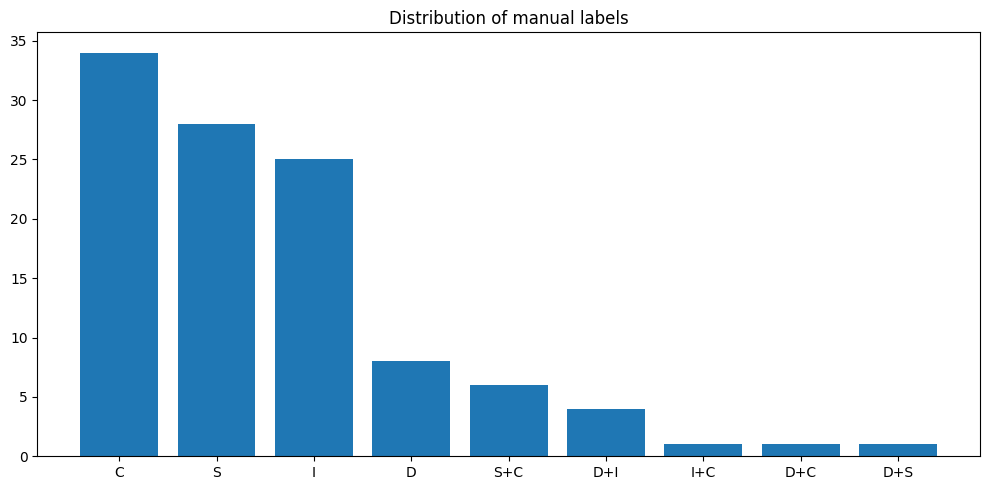

<Figure size 640x480 with 0 Axes>

In [13]:
manual_labels_tuples = emails_df_disc_label_no_empty['DISC_manual'].apply(lambda x: tuple(x) if isinstance(x, list) else ())
manual_labels_count = manual_labels_tuples.value_counts()

x_manual_labels = manual_labels_count.index.map(lambda x: 'Unlabelled' if isinstance(x, tuple) and len(x) == 0
                                 else '+'.join(x) if isinstance(x, tuple)
                                else str(x))


fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x_manual_labels, manual_labels_count.values)
ax.set_title('Distribution of manual labels')
plt.tight_layout()
plt.show()

plt.savefig('../figures/04_manual_labelled_emails_distribution.png')

In [14]:
emails_df_disc_label.to_csv('../data/03_cleaned_email_msg.csv', index=False)

## Use Rule-Based Keyword Matching to label sample emails

In [15]:
emails_df_rule_based_samples = emails_df_disc_label.sample(3000, random_state=32).copy()
rule_based_ids = emails_df_rule_based_samples.index.tolist()
print(rule_based_ids)

[22402, 21391, 8258, 27522, 44698, 28785, 35942, 47543, 6046, 44871, 1859, 56643, 10520, 34745, 51136, 14907, 38780, 16517, 41111, 12858, 5656, 33682, 57467, 42476, 26374, 24486, 1082, 48279, 11756, 3671, 8297, 45293, 61513, 63957, 53607, 40771, 53219, 37136, 29131, 23048, 39512, 26436, 20846, 61363, 34424, 42240, 41081, 24895, 37825, 39945, 26, 56268, 41968, 15925, 22747, 29144, 23178, 6903, 5476, 11589, 56200, 5698, 18845, 42393, 8888, 56336, 11602, 1006, 39426, 11681, 44091, 49126, 57696, 43466, 9219, 5162, 59120, 10669, 8336, 48656, 30576, 49753, 37954, 55830, 25669, 27309, 34021, 14233, 58550, 26258, 58422, 1500, 64315, 48122, 46337, 22860, 33628, 53618, 11676, 13940, 63399, 14048, 9537, 42481, 19296, 22541, 39522, 10023, 55512, 53658, 48881, 24094, 43561, 14227, 13280, 59494, 47037, 12805, 27416, 16971, 49061, 41461, 37303, 36273, 29953, 14467, 44297, 31606, 42521, 28148, 5670, 29376, 28363, 13282, 33581, 6011, 53186, 9035, 25879, 24516, 46253, 4346, 49783, 22811, 17787, 31233, 4

In [16]:
# lowercasing and remove punctuation
PUNC_PATTERN = re.compile(r'[^\w\s]')

def preprocess_text_for_rule_based(text):
    if not isinstance(text, str):
        return ''


    text = PUNC_PATTERN.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()
    return text

emails_df_rule_based_samples['Entire-Message'] = emails_df_rule_based_samples['Entire-Message'].apply(preprocess_text_for_rule_based)
emails_df_rule_based_samples.head()

,Entire-Message,DISC_rule,DISC_manual,DISC_final
22402,eott sub unit options plan stan this my unders...,NaN,[],NaN
21391,forest and noble gas marie since jay is out th...,NaN,[],NaN
8258,news quick read calif electric lottery an edit...,NaN,[],NaN
27522,29th floor tana the suite of offices on 29 wil...,NaN,[],NaN
44698,project teams detailed below are the project t...,NaN,[],NaN


In [17]:
DISC_KEYWORDS = {
    'D' : ["deadline", "urgent", "high priority",
        "challenge", "just do it", "action required",
        "at all costs", "make it happen", "asap",
        "take the lead", "take action", "do it now", "get this done",
        "ensure", "enforce", "absolutely", "direct", "right now", "immediately",
        "speed", "I want", "put questions to rest", "your fault",
        "your mistake", "your apologies", "your bad", "your error", "your oversight",
        "your slip", "your blunder", "your carelessness", "your inattention",
        "your neglect", "your omission", "your oversight", "I guarantee",
        "enough is enough", "fuck you"],
    'I' : ["excited", "great job", "share", "appreciate",
        "celebrate", "fun", "engage", "collaborate", "believe",
        "nice to hear", "amazing", "awesome", "fantastic", "get a hold of me",
        "chat", "jokes", "laugh", "smile", "happy", "good news", "favorite",
        "favourite", "celebrate", "congratulations", "kudos", "celebration", "party",
        "playing", "exciting", "thrilling", "enjoy", "game"],
    'S' : ["kindly", "let me know", "available", "cooperate", "understand",
        "follow up", "consistent", "appreciate your help", "thanks again",
        "dont worry", "help in any way I can", "let me know", "comfortable",
        "sorry for not responding", "thank you so much", "my fault", "my mistake",
        "my apologies", "my bad", "my error", "my oversight", "my slip", "my blunder",
        "my carelessness", "my inattention", "my neglect", "my omission", "my oversight",
        "sorry", "apologize for", "agree"],
    'C' : ["details", "data", "report", "analyze", "summary", "document", "proof",
        "schedule", "spreadsheet", "accuracy", "format", "process", "standards", "analysis",
        "compliance", "audit", "method", "evidence", "confirm", "structured", "sources",
        "review", "check", "validate", "verify", "validate", "as per", "according to",
        "in accordance with", "consistent with", "comply with", "follow", "procedure",
        "guideline", "manual", "policy", "regulation", "rule", "standard", "statute",
        "requirement", "specification", "protocol", "principle", "reconcile", "cross-check",
        "cross-reference", "corroborate", "substantiate", "authenticate", "confirm", "justify",
        "hindsight", "forethought", "foresight", "insight", "formula", "unjustified",
        "unsubstantiated", "unverified", "unvalidated", "unconfirmed", "unjust", "unreasonable",
        "looking into", "investigate", "examine", "probe", "scrutinize", "inspect", "identified",
        "final execution", "implementation", "calculation", "agreement", "calibrate"]
}

In [18]:
DISC_order = ['D', 'I', 'S', 'C']

def match_disc_label(msg, max_freq=1):
    labels_freq = {'D': 0, 'I': 0, 'S': 0, 'C': 0}
    for label, keywords in DISC_KEYWORDS.items():
        for word in keywords:
            if word in msg:
                labels_freq[label] += 1
    # print(labels_freq)

    filter_labels = {label: freq for label, freq in labels_freq.items() if freq > 0}
    if not filter_labels:
        return []

    # sorted_labels_freq = sorted(filter_labels.items(), key=lambda x: (-x[1], x[0]))
    sorted_labels_freq = sorted(filter_labels.items(), key=lambda x: x[0] in DISC_order)
    return [label for label, freq in sorted_labels_freq[:max_freq]]

# for use later
# emails_df_rule_based_samples['DISC_rule'] = emails_df_rule_based_samples['Entire-Message'].apply(match_disc_label_list)
# print("list: ", )
# for bar chart
emails_df_rule_based_samples['DISC_rule'] = emails_df_rule_based_samples['Entire-Message'].apply(match_disc_label)

print(emails_df_rule_based_samples.head(5))

label_count_tuple = emails_df_rule_based_samples['DISC_rule'].value_counts()
print(label_count_tuple)


                                          Entire-Message DISC_rule  \
22402  eott sub unit options plan stan this my unders...       [I]   
21391  forest and noble gas marie since jay is out th...        []   
8258   news quick read calif electric lottery an edit...       [C]   
27522  29th floor tana the suite of offices on 29 wil...       [I]   
44698  project teams detailed below are the project t...       [D]   

      DISC_manual  DISC_final  
22402          []         NaN  
21391          []         NaN  
8258           []         NaN  
27522          []         NaN  
44698          []         NaN  
DISC_rule
[S]    674
[C]    629
[]     612
[I]    582
[D]    503
Name: count, dtype: int64


DISC_rule
(S,)    674
(C,)    629
()      612
(I,)    582
(D,)    503
Name: count, dtype: int64


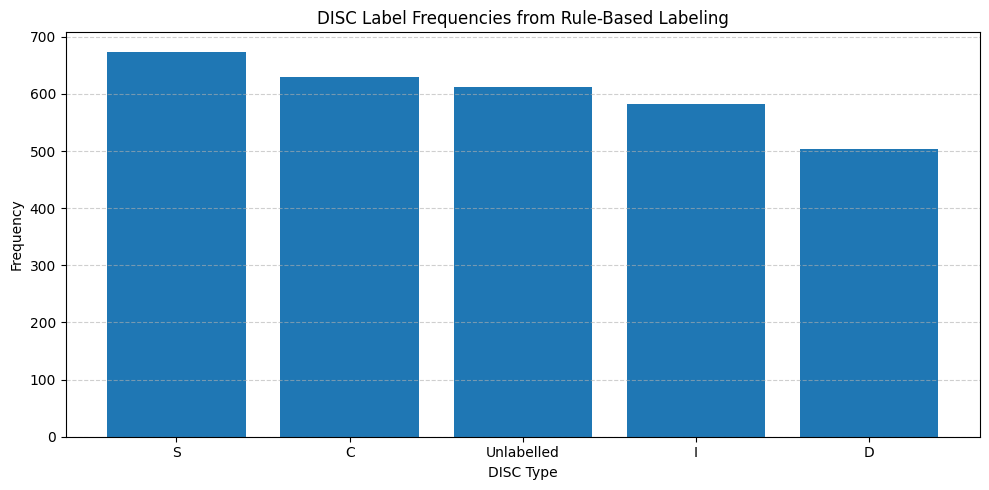

<Figure size 640x480 with 0 Axes>

In [19]:

label_count_tuple = emails_df_rule_based_samples['DISC_rule'].apply(lambda x: tuple(x) if isinstance(x, list) else ()).value_counts()

print(label_count_tuple)

x_labels = label_count_tuple.index.map(lambda x: 'Unlabelled' if isinstance(x, tuple) and len(x) == 0
                                 else '+'.join(x) if isinstance(x, tuple)
                                else str(x))


plt.figure(figsize=(10, 5))
plt.bar(x_labels, label_count_tuple.values)
plt.title("DISC Label Frequencies from Rule-Based Labeling")
plt.xlabel("DISC Type")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.savefig('../figures/04_rule_based_sample_label_freq.png')

## Combine the rule-based labelled data back into the main emails df

In [20]:

emails_df.loc[rule_based_ids, 'DISC_rule'] = emails_df_rule_based_samples['DISC_rule']
emails_df.sample(10, random_state=32)

/var/folders/cv/swyglqyx1tlc_6vc0p615fhr0000gn/T/ipykernel_60351/1149330898.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[list(['I']) list([]) list(['C']) ... list(['D']) list(['C']) list(['I'])]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  emails_df.loc[rule_based_ids, 'DISC_rule'] = emails_df_rule_based_samples['DISC_rule']


,Date,From,To,Subject,X_From,X_To,Message,Entire-Message,DISC_rule,DISC_manual,DISC_final
22402,"Wed, 15 Mar 2000 09:56:00 -0800 (PST)",michael.burke@enron.com,stanley.horton@enron.com,EOTT Sub Unit Options plan,Michael Burke,Stanley Horton,"Stan,\nThis my understanding of the proposal\n...","EOTT Sub Unit Options plan Stan,\nThis my unde...",[I],[],NaN
21391,"Mon, 19 Nov 2001 13:33:56 -0800 (PST)",max.sonnonstine@enron.com,marie.heard@enron.com,Forest and Noble Gas,"Sonnonstine, Max </O=ENRON/OU=NA/CN=RECIPIENTS...","Heard, Marie </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Marie,\nSince Jay is out this week, I'll be ""w...","Forest and Noble Gas Marie,\nSince Jay is out ...",[],[],NaN
8258,"Tue, 8 May 2001 03:52:00 -0700 (PDT)",jennifer.rudolph@enron.com,ca.team@enron.com,NEWS: quick read - calif electric lottery,Jennifer Rudolph,CA Team,* an editorial from today's Wall Street Journa...,NEWS: quick read - calif electric lottery * an...,[C],[],NaN
27522,"Wed, 19 Dec 2001 14:26:51 -0800 (PST)",lance.jameson@enron.com,tana.jones@enron.com,29th floor,"Jameson, Lance </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Jones, Tana </O=ENRON/OU=NA/CN=RECIPIENTS/CN=T...","Tana,\nThe suite of offices on 29 will be comp...","29th floor Tana,\nThe suite of offices on 29 w...",[I],[],NaN
44698,"Thu, 10 May 2001 03:57:00 -0700 (PDT)",wade.stubblefield@enron.com,"rogers.herndon@enron.com, meredith.eggleston@e...",Project Teams,Wade Stubblefield,"Rogers Herndon, Meredith M Eggleston, Don Blac...",Detailed below are the project teams identifie...,Project Teams Detailed below are the project t...,[D],[],NaN
28785,"Wed, 10 Jan 2001 07:49:00 -0800 (PST)",zimin.lu@enron.com,kenneth.parkhill@enron.com,Storage model change: Commodity Delta,Zimin Lu,Kenneth Parkhill,"Dear All,\nI change the storage model output t...",Storage model change: Commodity Delta Dear All...,[C],[],NaN
35942,"Mon, 18 Sep 2000 08:25:00 -0700 (PDT)",audrey.robertson@enron.com,"jeffery.fawcett@enron.com, steven.harris@enron...",Customer Meeting Attendance,Audrey Robertson,"Jeffery Fawcett, Steven Harris, Kevin Hyatt, L...","As of 3:00p today, Monday, September 18, I hav...","Customer Meeting Attendance As of 3:00p today,...",[C],[],NaN
47543,"Mon, 5 Nov 2001 11:16:13 -0800 (PST)",josie.jarnagin@enron.com,center.dl-portland@enron.com,Reminder-Flu Shots-Please respond by 11/6/01 i...,"Jarnagin, Josie </O=ENRON/OU=NA/CN=RECIPIENTS/...",DL-Portland World Trade Center </O=ENRON/OU=NA...,Flu Shot Clinic Sponsored By Enron\nWhen: Tues...,Reminder-Flu Shots-Please respond by 11/6/01 i...,[I],[],NaN
6046,"Fri, 14 Dec 2001 12:08:03 -0800 (PST)",ruth.jensen@enron.com,"ron.beidelman@enron.com, larry.campbell@enron....",CAM Applications to Engines with Catalytic Con...,"Jensen, Ruth </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Beidelman, Ron </O=ENRON/OU=NA/CN=RECIPIENTS/C...",I am trying to compile a list of engines with ...,CAM Applications to Engines with Catalytic Con...,[I],[],NaN
44871,"Tue, 26 Jun 2001 11:02:22 -0700 (PDT)",m..presto@enron.com,greg.wolfe@enron.com,Real-time opportunities,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...","Wolfe, Greg </O=ENRON/OU=NA/CN=RECIPIENTS/CN=G...","Greg,\nMy brother is looking to make a career ...","Real-time opportunities Greg,\nMy brother is l...",[D],[],NaN


In [21]:
def combine_labels(row):
    man = row['DISC_manual']
    rule = row['DISC_rule']
    if isinstance(man, list) and len(man) > 0:
        return man
    elif isinstance(rule, list) and len(rule) > 0:
        return rule
    else:
        return []

emails_df['DISC_final'] = emails_df.apply(combine_labels, axis=1)
emails_df.to_csv('../data/04_all_emails_with_labelled_samples.csv', index=False)

In [22]:
emails_df.sample(10, random_state=2)

,Date,From,To,Subject,X_From,X_To,Message,Entire-Message,DISC_rule,DISC_manual,DISC_final
42085,"Wed, 13 Oct 1999 10:18:00 -0700 (PDT)",gerald.nemec@enron.com,"eric.gillaspie@enron.com, paul_pfeffer@bakerbo...",No Subject,Gerald Nemec,"Eric Gillaspie, paul_pfeffer@bakerbotts.com",AP--\nIn a shocking move that will have the re...,No Subject AP--\nIn a shocking move that will ...,NaN,[],[]
48868,"Mon, 9 Jul 2001 11:59:14 -0700 (PDT)",john.malowney@enron.com,diana.scholtes@enron.com,Sale to Cenex,"Malowney, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Scholtes, Diana </O=ENRON/OU=NA/CN=RECIPIENTS/...",This morning EPMI sold Cenex 7 MW flat deliver...,Sale to Cenex This morning EPMI sold Cenex 7 M...,NaN,[],[]
47119,"Fri, 11 May 2001 09:53:00 -0700 (PDT)",michael.tribolet@enron.com,djst@pge.com,ISO PX draft figures,Michael Tribolet,DJST@PGE.COM@SMTP@enronXgate,Please find our draft PX/ISO figures. We have ...,ISO PX draft figures Please find our draft PX/...,NaN,[],[]
39539,"Thu, 3 Jan 2002 13:41:26 -0800 (PST)",jd.buss@enron.com,"a..martin@enron.com, brian.redmond@enron.com",Revised Business Plan for Texas,"Buss, Jd </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JERE...","Martin, Thomas A. </O=ENRON/OU=NA/CN=RECIPIENT...",This is an updated business plan based on some...,Revised Business Plan for Texas This is an upd...,NaN,[],[]
33671,"Wed, 18 Oct 2000 00:21:00 -0700 (PDT)",john.lavorato@enron.com,ted.bland@enron.com,Re: Associate/Analyst Super Saturday Participa...,John J Lavorato,Ted C Bland,Ted\nCall me. I told Charlene that I would do ...,Re: Associate/Analyst Super Saturday Participa...,NaN,[],[]
42806,"Fri, 18 May 2001 08:30:00 -0700 (PDT)",mary.ogden@enron.com,stephanie.miller@enron.com,Corrected C.A.,Mary Ogden,Stephanie Miller,Dear Stephanie: Please see that attached corre...,Corrected C.A. Dear Stephanie: Please see that...,NaN,[],[]
27505,"Mon, 22 Oct 2001 13:01:26 -0700 (PDT)",georgi.landau@enron.com,"griff.gray@enron.com, tana.jones@enron.com, ka...",NEW EOL SETUP,"Landau, Georgi </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Gray, Mary Griff </O=ENRON/OU=NA/CN=RECIPIENTS...",FYI -\nA new (shell) Master Financial Agreemen...,NEW EOL SETUP FYI -\nA new (shell) Master Fina...,NaN,[],[]
381,"Mon, 25 Sep 2000 10:15:00 -0700 (PDT)",john.arnold@enron.com,slafontaine@globalp.com,Re: sept 29th,John Arnold,slafontaine@globalp.com @ ENRON,Steve:\nSorry for the delay. I was actually ou...,Re: sept 29th Steve:\nSorry for the delay. I w...,NaN,[],[]
47918,"Wed, 10 May 2000 09:46:00 -0700 (PDT)",twanda.sweet@enron.com,rex.rogers@enron.com,TVA,Twanda Sweet,Rex Rogers,"On [DATE], Enron North America (Enron) filed a...","TVA On [DATE], Enron North America (Enron) fil...",NaN,[],[]
50541,"Tue, 17 Apr 2001 08:10:00 -0700 (PDT)",becky.spencer@enron.com,bhendry@houston.rr.com,Bermuda Phone Numbers,Becky Spencer,bhendry@houston.rr.com,Christoher Garrad\nConyers Dill & Pearman Firm...,Bermuda Phone Numbers Christoher Garrad\nConye...,NaN,[],[]


## Encode DISC_final using MultiLabelBinarizer

In [23]:
# filter out the unlabelled rows
labelled_emails_df = emails_df[emails_df['DISC_final'].apply(lambda x: len(x) > 0)]
labelled_emails_df

,Date,From,To,Subject,X_From,X_To,Message,Entire-Message,DISC_rule,DISC_manual,DISC_final
26,"Fri, 25 Aug 2000 03:30:00 -0700 (PDT)",phillip.allen@enron.com,brad.mcsherry@enron.com,"Cc: [EMAIL], [EMAIL]",Phillip K Allen,Brad McSherry,"Brad,\nWith regard to Tori Kuykendall, I would...","Cc: [EMAIL], [EMAIL] Brad,\nWith regard to Tor...",[S],[],[S]
39,"Mon, 10 Jul 2000 06:54:00 -0700 (PDT)",phillip.allen@enron.com,al.pollard@enron.com,Re: Katy flatlands,Phillip K Allen,Al Pollard,"Al,\nI am not in good enough shape to ride a c...","Re: Katy flatlands Al,\nI am not in good enoug...",[D],[],[D]
72,"Tue, 24 Apr 2001 13:05:00 -0700 (PDT)",phillip.allen@enron.com,jsmith@austintx.com,Re: The Stage,Phillip K Allen,Jeff Smith <jsmith@austintx.com>,I just spoke to the insurance company. They ar...,Re: The Stage I just spoke to the insurance co...,[C],[],[C]
128,"Mon, 5 Mar 2001 07:21:00 -0800 (PST)",phillip.allen@enron.com,cbpres@austin.rr.com,"Cc: [EMAIL], [EMAIL]",Phillip K Allen,cbpres@austin.rr.com,"George,\nI am back in the office and ready to ...","Cc: [EMAIL], [EMAIL] George,\nI am back in the...",[I],[],[I]
202,"Wed, 13 Dec 2000 06:35:00 -0800 (PST)",critical.notice@enron.com,"ywang@enron.com, patti.sullivan@enron.com, phi...",New Notice from Transwestern Pipeline Co.,critical.notice@Enron.com,"ywang@Enron.com, Patti.Sullivan@Enron.com, Phi...",Transwestern Pipeline Co. posted new notice(s)...,New Notice from Transwestern Pipeline Co. Tran...,[C],[],[C]
...,...,...,...,...,...,...,...,...,...,...,...
64276,"Tue, 5 Jun 2001 14:50:50 -0700 (PDT)",andy.zipper@enron.com,sgross@warburgpincus.com,RE: Conagra is our newest beta customer!,"Zipper, Andy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","'""Gross, Stewart"" <sgross@warburgpincus.com>@E...","Stewart,\nIt is my strong belief that Kiodex w...",RE: Conagra is our newest beta customer! Stewa...,[D],[],[D]
64331,"Wed, 23 May 2001 09:35:04 -0700 (PDT)",andy.zipper@enron.com,greg.piper@enron.com,RE: EnronOnline in the palm of your hand,"Zipper, Andy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Piper, Greg </O=ENRON/OU=NA/CN=RECIPIENTS/CN=G...",I think the note I sent to Steve plus the fact...,RE: EnronOnline in the palm of your hand I thi...,[D],[],[D]
64333,"Thu, 24 May 2001 13:44:47 -0700 (PDT)",andy.zipper@enron.com,lydia.cannon@enron.com,Origination meeting,"Zipper, Andy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Cannon, Lydia </O=ENRON/OU=NA/CN=RECIPIENTS/CN...",Can you schedule and send out the following no...,Origination meeting Can you schedule and send ...,[I],[],[I]
64334,"Fri, 25 May 2001 06:49:39 -0700 (PDT)",andy.zipper@enron.com,wes.colwell@enron.com,Drew K.,"Zipper, Andy </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Colwell, Wes </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",I declined to review Drew because I feel I hav...,Drew K. I declined to review Drew because I fe...,[I],[],[I]


In [24]:
labelled_emails_df.isnull().sum()

Date              0
From              0
To                0
Subject           0
X_From            0
X_To              0
Message           0
Entire-Message    0
DISC_rule         0
DISC_manual       0
DISC_final        0
dtype: int64

In [25]:
mlb = MultiLabelBinarizer(classes=['D', 'I', 'S', 'C'])
mlb.fit(labelled_emails_df['DISC_final']) # Learns the unique labels
mlb.classes_ # The labels learned in sorted order

array(['D', 'I', 'S', 'C'], dtype=object)

In [26]:
Y = mlb.transform(labelled_emails_df['DISC_final']) # Transforms the labels into binary form
# print(Y)

one_hot_df = pd.DataFrame(Y, columns=mlb.classes_, index=labelled_emails_df.index)
# print(one_hot_df.head())

labelled_emails_df = pd.concat([labelled_emails_df, one_hot_df], axis=1)
print(labelled_emails_df.head())
print('info: ', labelled_emails_df.info())
print('isnull: ', labelled_emails_df.isnull().sum())

                                      Date                       From  \
26   Fri, 25 Aug 2000 03:30:00 -0700 (PDT)    phillip.allen@enron.com   
39   Mon, 10 Jul 2000 06:54:00 -0700 (PDT)    phillip.allen@enron.com   
72   Tue, 24 Apr 2001 13:05:00 -0700 (PDT)    phillip.allen@enron.com   
128   Mon, 5 Mar 2001 07:21:00 -0800 (PST)    phillip.allen@enron.com   
202  Wed, 13 Dec 2000 06:35:00 -0800 (PST)  critical.notice@enron.com   

                                                    To  \
26                             brad.mcsherry@enron.com   
39                                al.pollard@enron.com   
72                                 jsmith@austintx.com   
128                               cbpres@austin.rr.com   
202  ywang@enron.com, patti.sullivan@enron.com, phi...   

                                       Subject                     X_From  \
26                        Cc: [EMAIL], [EMAIL]            Phillip K Allen   
39                          Re: Katy flatlands            

In [27]:
labelled_emails_df.to_csv('../data/04_encoded_labelled_emails.csv', index=False)

In [28]:
# emails_df['DISC_rule'].dropna().apply(lambda x: len(x) if isinstance(x, (list, tuple)) else 0).value_counts().sort_index()
